# Elastic Metric for Cell Boundary Analysis

## Notebook setup

In [1]:
import os
import subprocess
import geomstats.backend as gs

geomstats_gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)
os.chdir(geomstats_gitroot_path[:-1])
print("Working directory: ", os.getcwd())

import warnings
warnings.filterwarnings("ignore")

import sys
sys_dir = os.path.dirname(os.getcwd()
                          )
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)

INFO: Using numpy backend


Working directory:  /home/wanxinli/dyn
Directory added to path:  /home/wanxinli


## Standard imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn import manifold
from joblib import Parallel, delayed
from numba import jit, njit, prange

## Project-specific imports

In [4]:
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import R2, DiscreteCurves, ClosedDiscreteCurves

from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.kmeans import RiemannianKMeans
from geomstats.learning.mdm import RiemannianMinimumDistanceToMeanClassifier
from geomstats.learning.pca import TangentPCA

import dyn.dyn.datasets.experimental as experimental
import dyn.dyn.features.basic as basic
import dyn.viz as viz

viz.init_matplotlib()
%config InlineBackend.figure_formats = ['svg']

We import the space of curves shapes equipped with different elastic metrics:
- the square root velocity metric (SRV), which is the canonical elastic metrics,
- the generalized elastic metric with parameters a, b.

# Load the dataset of interest

We load an experimental cell dataset with `n_cells` and `n_sampling_points` sampled along the boundary of each cell. 

For faster notebook execution, use small value for `n_cells` and `n_sampling_points`.

In [28]:
dataset_name = "osteosarcoma"  # "osteosarcoma" #  "retinal"
# dataset_name = "retinal"
assert dataset_name in ["osteosarcoma", "retinal"]

if dataset_name == "osteosarcoma":
    n_cells = 650
    n_sampling_points = 100
    labels_a_name = "lines"
    labels_b_name = "mutations"
elif dataset_name == "retinal":
    # n_cells = 3871
    # n_sampling_points = 100
    n_cells = 100
    n_sampling_points = 10
    labels_a_name = "surfaces"
    labels_b_name = "mutations"

quotient = ["scaling", "rotation"]


SAVEFIG = True
if SAVEFIG:
    figs_dir = os.path.join(os.getcwd(), f"dyn/saved_figs/{dataset_name}")
    print(f"Will save figs to {figs_dir}")
    from datetime import datetime

    now = datetime.now().strftime("%Y%m%d_%H:%M:%S")
    print(now)

Will save figs to /home/wanxinli/dyn/dyn/saved_figs/osteosarcoma
20230216_11:09:40


The variable `quotient` is used to define what is called a `cell_shape`.
- `cells`: has only removed the effect of the translation
- `cell_shapes`: additionally removes what is written in `quotient`: the effect of the scaling, and of the rotation.

Note: in the previous analysis, we were using the linear euclidean metric on cells (without translation), and the srv metric on cell shapes (without translation, scaling and rotation).

This notebook compares the linear versus the srv metric on data on which the same preprocessing has been performed.

In [6]:
if dataset_name == "osteosarcoma":
    cells, cell_shapes, labels_a, labels_b = experimental.load_treated_osteosarcoma_cells(
        n_cells=n_cells, n_sampling_points=n_sampling_points, quotient=quotient
    )
    
else:
    cells, cell_shapes, labels_a, labels_b = experimental.load_mutated_retinal_cells(
        n_cells=n_cells, n_sampling_points=n_sampling_points, quotient=quotient
    )

... Selecting only a random subset of 650 / 650 cells.
... Interpolating: Cell boundaries have 100 samplings points.
... Removing potential duplicate sampling points on cell boundaries.

- Cells: quotienting translation.
- Cell shapes: quotienting scaling (length).
- Cell shapes: quotienting rotation.


In [7]:
do_not_quotient = True
if do_not_quotient:
    cell_shapes = cells

# Preprocessing

# Remove dlm8 cells


In [8]:
def remove_cells(cells, cell_shapes, labels_a, labels_b, delete_indices):
    """ 
    Remove cells of control group from cells, cell_shapes, labels_a, labels_b,
    the parameters returned from load_treated_osteosarcoma_cells
    Also update n_cells

    :param list[int] delete_indices: the indices to delete
    """
    
    # Delete elements
    cells = np.delete(np.array(cells), delete_indices, axis=0)
    cell_shapes = np.delete(np.array(cell_shapes), delete_indices, axis=0)
    labels_a = list(np.delete(np.array(labels_a), delete_indices, axis=0))
    labels_b = list(np.delete(np.array(labels_b), delete_indices, axis=0))
    global n_cells
    n_cells = cells.shape[0]

    return cells, cell_shapes, labels_a, labels_b

In [9]:
# Find all dlm8 cells
dlm8_indices = []
for i in range(len(labels_a)):
    if labels_a[i] == "dlm8":
        dlm8_indices.append(i)

# Delete all dlm8 cells
cells, cell_shapes, labels_a, labels_b = remove_cells(cells, cell_shapes, labels_a, labels_b, dlm8_indices)

## Remove outliers by DeCOr-MDS using linear metric

In [10]:
from nsimplices import *
CURVES_SPACE = DiscreteCurves(R2)
SRV_METRIC = CURVES_SPACE.srv_metric

# Prepare functions for calculating pairwise distances
def srv_dist(cell1, cell2):
    return SRV_METRIC.dist(cell1, cell2) / n_sampling_points

@jit(nopython=False, forceobj=True)
def parallel_dist(cells, dist_fun):
    pairwise_dists = np.zeros((n_cells, n_cells))
    for i in prange(n_cells):
        for j in prange(i + 1, n_cells):
            pairwise_dists[i, j] = dist_fun(cells[i], cells[j]) / n_sampling_points
    pairwise_dists += pairwise_dists.T
    return pairwise_dists

In [11]:
# compute pairwise distances
pairwise_dists = parallel_dist(cell_shapes, dist_fun=srv_dist)

# run DeCOr-MDS
dim_start = 2
dim_end = 2
feature_num = 2
outlier_indices, subspace_dim , corr_pairwise_dis, corr_coord = nsimplices(pairwise_dists, feature_num, dim_start, dim_end, std_multi=2)


INFO: finding looplift candidates


In [12]:
""" 
Remove cells
"""

# Find indices for cells that are dlm8

cells, cell_shapes, labels_a, labels_b = remove_cells(cells, cell_shapes, labels_a, labels_b, outlier_indices)

In [13]:
print("cells shape is:", cells.shape)
print("cell_shapes shape is:", cell_shapes.shape)
print("labels_a shape is:", len(labels_a))
print("labels_b shape is:", len(labels_b))
print("n_cells is:", n_cells)

cells shape is: (334, 100, 2)
cell_shapes shape is: (334, 100, 2)
labels_a shape is: 334
labels_b shape is: 334
n_cells is: 334


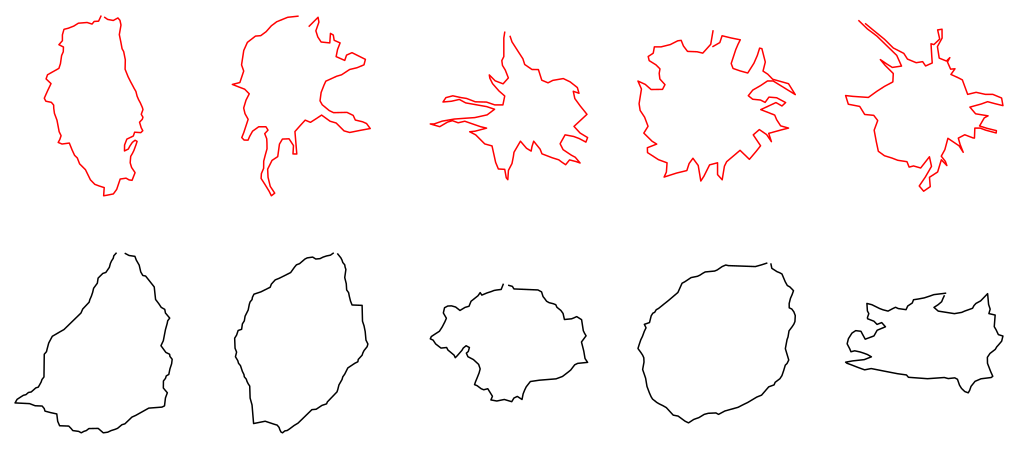

<Figure size 432x288 with 0 Axes>

In [14]:
# plot the some outlier cells and some normal cells

normal_indices=[i for i in range(pairwise_dists.shape[0]) if i not in outlier_indices] # list of normal points 

fig = plt.figure(figsize=(18, 8))
nrows = 2
ncols = 5 # plot 5 normal cells, and 5 outlier cells

# plot outlier cells
for i in range(ncols):
    outlier_index = outlier_indices[i]
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.plot(cell_shapes[outlier_index, :, 0], cell_shapes[outlier_index, :, 1], "red")
    ax.set_aspect("equal")
    ax.axis("off")
    

# plot normal cells
for i in range(ncols):
    normal_index = normal_indices[i]
    ax = fig.add_subplot(nrows, ncols, i+1+ncols)
    ax.plot(cell_shapes[normal_index, :, 0], cell_shapes[normal_index, :, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")

plt.show()
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_normal_outlier.svg"))

In [15]:
labels_a_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(labels_a))}
labels_b_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(labels_b))}

print(f"Dictionary associated to label \"{labels_a_name}\":")
print(labels_a_dict)
print(f"Dictionary associated to label \"{labels_b_name}\":")
print(labels_b_dict)

Dictionary associated to label "lines":
{'dunn': 0}
Dictionary associated to label "mutations":
{'control': 0, 'cytd': 1, 'jasp': 2}


## Define Shape Spaces

In [16]:
R1 = Euclidean(dim=1)
CLOSED_CURVES_SPACE = ClosedDiscreteCurves(R2)
CURVES_SPACE = DiscreteCurves(R2)
SRV_METRIC = CURVES_SPACE.srv_metric
L2_METRIC = CURVES_SPACE.l2_curves_metric

ELASTIC_METRIC = {}
METRICS = {}
METRICS["Linear"] = L2_METRIC
METRICS["SRV"] = SRV_METRIC

# Sample Means

We compare results when computing the mean cell versus the mean cell shapes with different elastic metrics.

In [17]:
means = {}

means["Linear"] = gs.mean(cell_shapes, axis=0)
means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        method="default").fit(cell_shapes).estimate_

ELASTIC_METRIC = {}
AS = [1, 2, 0.75, 0.5, 0.25, 0.01] #, 1.6] #, 1.4, 1.2, 1, 0.5, 0.2, 0.1]
BS = [0.5, 1, 0.5, 0.5, 0.5, 0.5] #, 2, 2, 2, 2, 2, 2, 2]
for a, b in zip(AS, BS):
    ELASTIC_METRIC[a, b] = DiscreteCurves(R2, a=a, b=b).elastic_metric

In [18]:
NEW_AS = [0.75, 0.5, 0.25, 0.01] #, 1.6] #, 1.4, 1.2, 1, 0.5, 0.2, 0.1]
NEW_BS = [0.5, 0.5, 0.5, 0.5] #, 2, 2, 2, 2, 2, 2, 2]

# Distances to the mean(s)

We compute the distances between:
- every cell in the dataset
- and the mean cell shape, according to the different metrics: Euclidean (Linear), SRV and Elastic Metrics.

In [19]:
R1 = Euclidean(dim=1)
CLOSED_CURVES_SPACE = ClosedDiscreteCurves(R2)
CURVES_SPACE = DiscreteCurves(R2)
SRV_METRIC = CURVES_SPACE.srv_metric
L2_METRIC = CURVES_SPACE.l2_curves_metric

ELASTIC_METRIC = {}
METRICS = {}
METRICS["Linear"] = L2_METRIC
METRICS["SRV"] = SRV_METRIC

In [20]:
means = {}

means["Linear"] = gs.mean(cell_shapes, axis=0)
means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        method="default").fit(cell_shapes).estimate_

In [21]:
NEW_AS = [0.75, 0.5, 0.25, 0.01] #, 1.6] #, 1.4, 1.2, 1, 0.5, 0.2, 0.1]
NEW_BS = [0.5, 0.5, 0.5, 0.5] #, 2, 2, 2, 2, 2, 2, 2]

In [22]:
dists = {}

dists["Linear"] = [gs.linalg.norm(means["Linear"] - cell) / n_sampling_points for cell in cells]

dists["SRV"] = [
    SRV_METRIC.dist(means["SRV"], cell) / n_sampling_points for cell in cells
]

for a, b in zip(NEW_AS, NEW_BS):
    ELASTIC_METRIC[a, b] = DiscreteCurves(R2, a=a, b=b).elastic_metric

for a, b in zip(NEW_AS, NEW_BS):
    means[a, b] = FrechetMean(
            metric=ELASTIC_METRIC[a, b], 
            method="default").fit(cell_shapes).estimate_

for a, b in zip(NEW_AS, NEW_BS):
    dists[a, b] =  [
    ELASTIC_METRIC[a, b].dist(means[a, b], cell) / n_sampling_points for cell in cells
]

In [23]:
dists_summary = pd.DataFrame(
    data={
        labels_a_name: labels_a,
        labels_b_name: labels_b,
        "Linear": dists["Linear"],
        "SRV": dists["SRV"],
    }
)

for a, b in zip(NEW_AS, NEW_BS):
    dists_summary[f"Elastic({a}, {b})"] = dists[a, b]

In [24]:
dists_summary.head()

,lines,mutations,Linear,SRV,"Elastic(0.75, 0.5)","Elastic(0.5, 0.5)","Elastic(0.25, 0.5)","Elastic(0.01, 0.5)"
0,dunn,control,1.300461,0.096795,0.082027,0.068348,0.061597,0.061488
1,dunn,control,1.740802,0.097345,0.081931,0.067158,0.059908,0.060047
2,dunn,control,1.444199,0.133095,0.111539,0.084959,0.058803,0.046852
3,dunn,control,1.794187,0.098408,0.080170,0.062415,0.052247,0.051272
4,dunn,control,2.134993,0.177942,0.151595,0.115952,0.075485,0.052250


# Quantiles of distribution of distances to the mean(s)

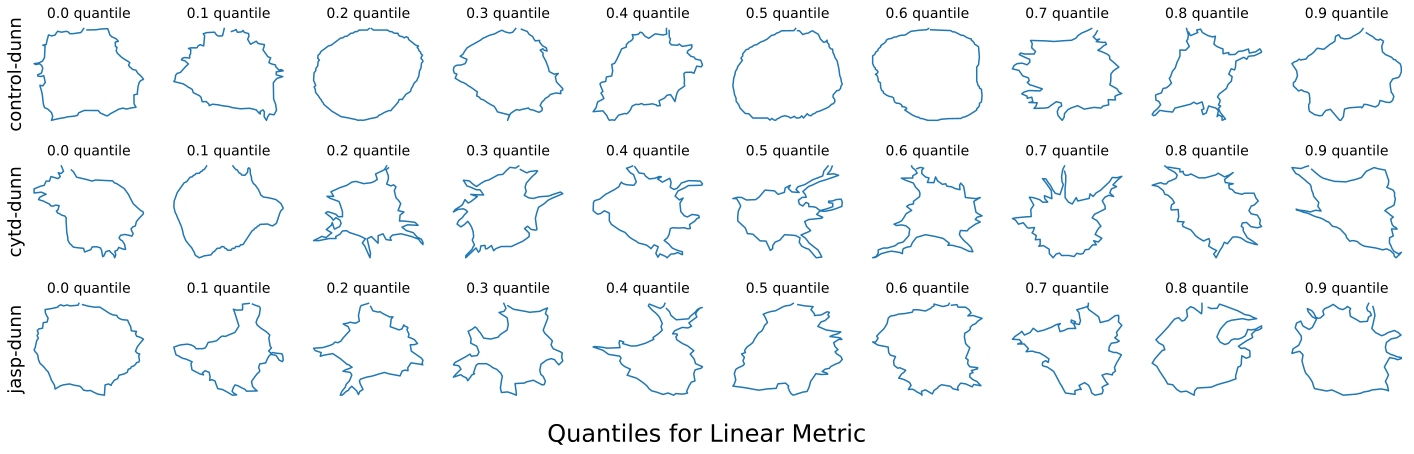

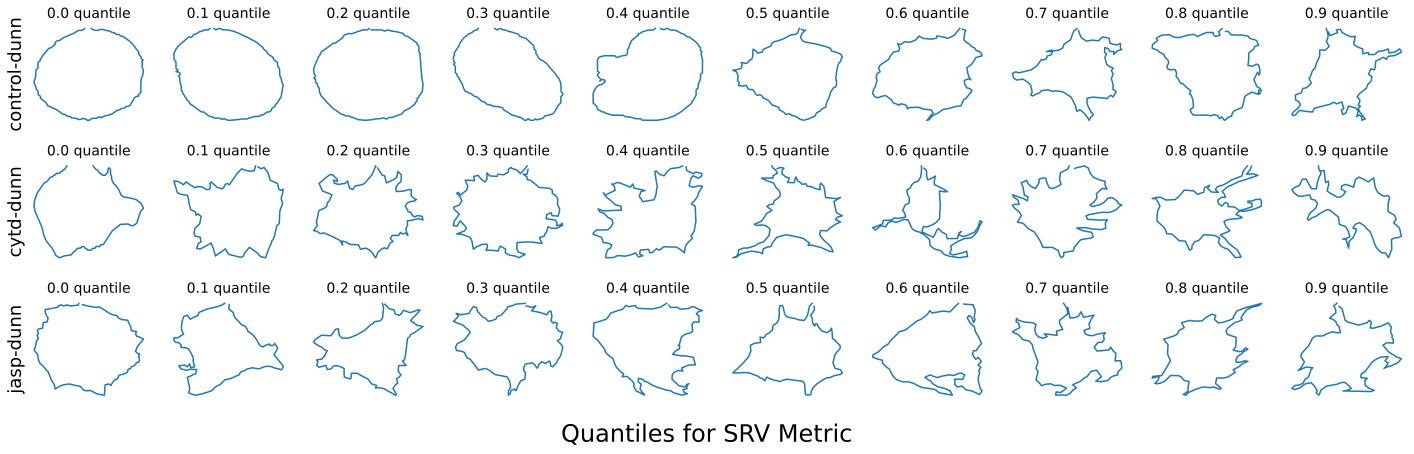

In [26]:
""" 
Test this plot if do not remove any cells
"""

for dist_name in ["Linear", "SRV"]:
    n_quantiles = 10
    fig, axes = plt.subplots(
        nrows=len(labels_b_dict) * len(labels_a_dict),
        ncols=n_quantiles,
        figsize=(20, 2 * len(labels_a_dict) * len(labels_b_dict)),
    )

    for i_lab_b, label_b in enumerate(np.unique(labels_b)):
        for j_lab_a, label_a in enumerate(np.unique(labels_a)):
            dists_list = dists_summary[dist_name][
                        dists_summary[labels_a_name] == label_a][dists_summary[labels_b_name] == label_b]
            # The following line ennsures that all values of distances are different, 
            # which is required in order to use the function "sorted" later
            dists_list = [d + 0.000001 * gs.random.rand(1)[0] for d in dists_list]
            cells_list = [cell for cell, lab_a, lab_b in zip(cell_shapes, labels_a, labels_b) if lab_a == label_a and lab_b == label_b]
            assert len(dists_list) == len(dists_list)
            n_cells = len(dists_list)

            zipped_lists = zip(dists_list, cells_list)
            sorted_pairs = sorted(zipped_lists)

            tuples = zip(*sorted_pairs)
            sorted_dists_list, sorted_cells_list = [list(t) for t in tuples]
            for i_quantile in range(n_quantiles):
                quantile = int(0.1 * n_cells * i_quantile)
                one_cell = sorted_cells_list[quantile]
                ax = axes[len(np.unique(labels_a)) * i_lab_b + j_lab_a, i_quantile]
                ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{j_lab_a}")
                ax.set_title(f"0.{i_quantile} quantile", fontsize=14)
                # Turn off tick labels
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                ax.set_xticks([])
                ax.set_yticks([])
                ax.spines["top"].set_visible(False)
                ax.spines["right"].set_visible(False)
                ax.spines["bottom"].set_visible(False)
                ax.spines["left"].set_visible(False)
                if i_quantile == 0:
                    ax.set_ylabel(f"{label_b}-{label_a}", rotation=90, fontsize=18)
    plt.tight_layout()
    plt.suptitle(f"Quantiles for {dist_name} Metric", y=-0.01, fontsize=24)
    if SAVEFIG:
        plt.savefig(os.path.join(figs_dir, f"{now}_quantiles_{dist_name}.svg"))

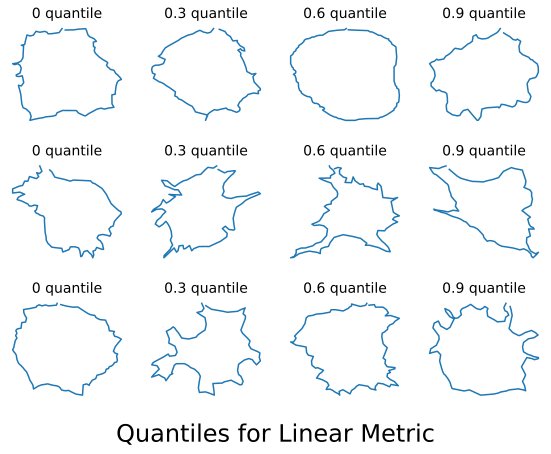

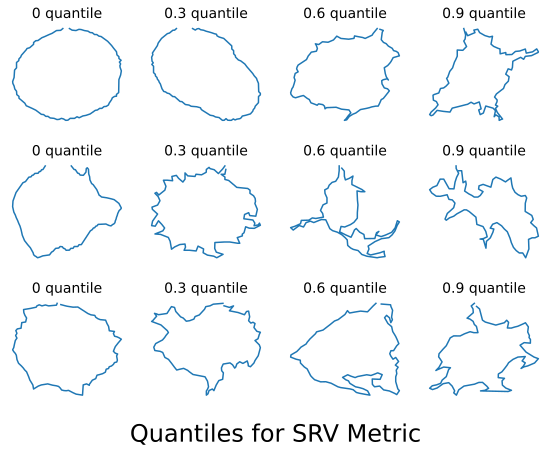

In [29]:
for dist_name in ["Linear", "SRV"]:
    quantiles = [0, 0.3, 0.6, 0.9]
    fig, axes = plt.subplots(
        nrows=len(labels_b_dict) * len(labels_a_dict),
        ncols=len(quantiles),
        figsize=(8, 2 * len(labels_a_dict) * len(labels_b_dict)),
    )

    for i_lab_b, label_b in enumerate(np.unique(labels_b)):
        for j_lab_a, label_a in enumerate(np.unique(labels_a)):
            dists_list = dists_summary[dist_name][
                        dists_summary[labels_a_name] == label_a][dists_summary[labels_b_name] == label_b]
            # The following line ennsures that all values of distances are different, 
            # which is required in order to use the function "sorted" later
            dists_list = [d + 0.000001 * gs.random.rand(1)[0] for d in dists_list]
            cells_list = [cell for cell, lab_a, lab_b in zip(cell_shapes, labels_a, labels_b) if lab_a == label_a and lab_b == label_b]
            assert len(dists_list) == len(dists_list)
            n_cells = len(dists_list)

            zipped_lists = zip(dists_list, cells_list)
            sorted_pairs = sorted(zipped_lists)

            tuples = zip(*sorted_pairs)
            sorted_dists_list, sorted_cells_list = [list(t) for t in tuples]
            for i, cur_quantile in enumerate(quantiles):
                quantile = int(n_cells * cur_quantile)
                one_cell = sorted_cells_list[quantile]
                ax = axes[len(np.unique(labels_a)) * i_lab_b + j_lab_a, i]
                ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{j_lab_a}")
                ax.set_title(f"{cur_quantile} quantile", fontsize=14)
                # Turn off tick labels
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                ax.set_xticks([])
                ax.set_yticks([])
                ax.spines["top"].set_visible(False)
                ax.spines["right"].set_visible(False)
                ax.spines["bottom"].set_visible(False)
                ax.spines["left"].set_visible(False)
                # if cur_quantile == 0:
                #     ax.set_ylabel(f"{label_b}-{label_a}", rotation=90, fontsize=18)
    plt.tight_layout()
    plt.suptitle(f"Quantiles for {dist_name} Metric", y=-0.01, fontsize=24)
    if SAVEFIG:
        plt.savefig(os.path.join(figs_dir, f"{now}_quantiles_{dist_name}.svg"))